In [47]:
import numpy as np
# import pygame
import gymnasium as gym
from gym import spaces
# from spaces import MultiBinary
import json
import math

def get_vectormap(vectormap):
    f = open(vectormap)
    data = json.load(f)
    return data

def get_image_size(vectormap, scaling = 10):
    # get the size of the image
    x = []
    y = []
    for line in vectormap:
        for point in line:
            x.append(line[point]['x'])
            y.append(line[point]['y'])
    return math.ceil(max(x) - min(x)) * scaling + 1,  math.ceil(max(y) - min(y)) * scaling  + 1

def get_image_min_max(vectormap):
    # get the size of the image
    x = []
    y = []
    for line in vectormap:
        for point in line:
            x.append(line[point]['x'])
            y.append(line[point]['y'])
    return min(x), min(y), max(x), max(y)

def get_map_channel(vectormap, image_size_x, image_size_y, x_min, y_min, scaling = 10):
    # first channel is the map, which is a binary image where 0 is empty space and 1 is occupied space
    map_channel = np.zeros((image_size_x, image_size_y))
    # count_horizontal = 0
    # count_vertical = 0
    # count_diagonal = 0
    for line in vectormap:
        start_x = round((line['p0']['x'] - x_min) * scaling)
        start_y = round((line['p0']['y'] - y_min) * scaling)
        end_x = round((line['p1']['x'] - x_min) * scaling)
        end_y = round((line['p1']['y'] - y_min) * scaling)
        
        # horizontal line
        if start_y == end_y:
            # continue
            start_x, end_x = min(start_x, end_x), max(start_x, end_x)
            map_channel[start_x:end_x, start_y] = 1
            # count_horizontal += 1
        # vertical line
        elif start_x == end_x:
            # continue
            start_y, end_y = min(start_y, end_y), max(start_y, end_y)
            map_channel[start_x, start_y:end_y] = 1
            # count_vertical += 1
        # diagonal line
        else:
            # along x axis
            (start_x, start_y), (end_x, end_y) = sorted([(start_x, start_y), (end_x, end_y)], key=lambda x: x[0])
            slope = (end_y - start_y) / (end_x - start_x)
            for x in range(start_x, end_x + 1):
                y = start_y + slope * (x - start_x)
                map_channel[round(x), round(y)] = 1
            
            # along y axis
            (start_x, start_y), (end_x, end_y) = sorted([(start_x, start_y), (end_x, end_y)], key=lambda x: x[1])
            slope = (end_x - start_x) / (end_y - start_y)
            for y in range(start_y, end_y + 1):
                x = start_x + slope * (y - start_y)
                map_channel[round(x), round(y)] = 1
            # count_diagonal += 1
    # print("horizontal: ", count_horizontal, "vertical: ", count_vertical, "diagonal: ", count_diagonal)
    return map_channel

In [70]:
def transform_xy_to_map(x, y, x_min, y_min, scaling = 10):
    return round((x - x_min) * scaling), round((y - y_min) * scaling)


def get_agent_channel(agent_x, agent_y, agent_dims, x_min, y_min, image_size_x, image_size_y, scaling = 10):
    agent_channel = np.zeros((image_size_x, image_size_y))
    agent_x, agent_y = transform_xy_to_map(agent_x, agent_y, x_min, y_min, scaling)
    for i in range(agent_x - agent_dims[0]//2, agent_x + agent_dims[0]//2):
        for j in range(agent_y - agent_dims[1]//2, agent_y + agent_dims[1]//2):
            agent_channel[i, j] = 1
    return agent_channel


dims: 891 691


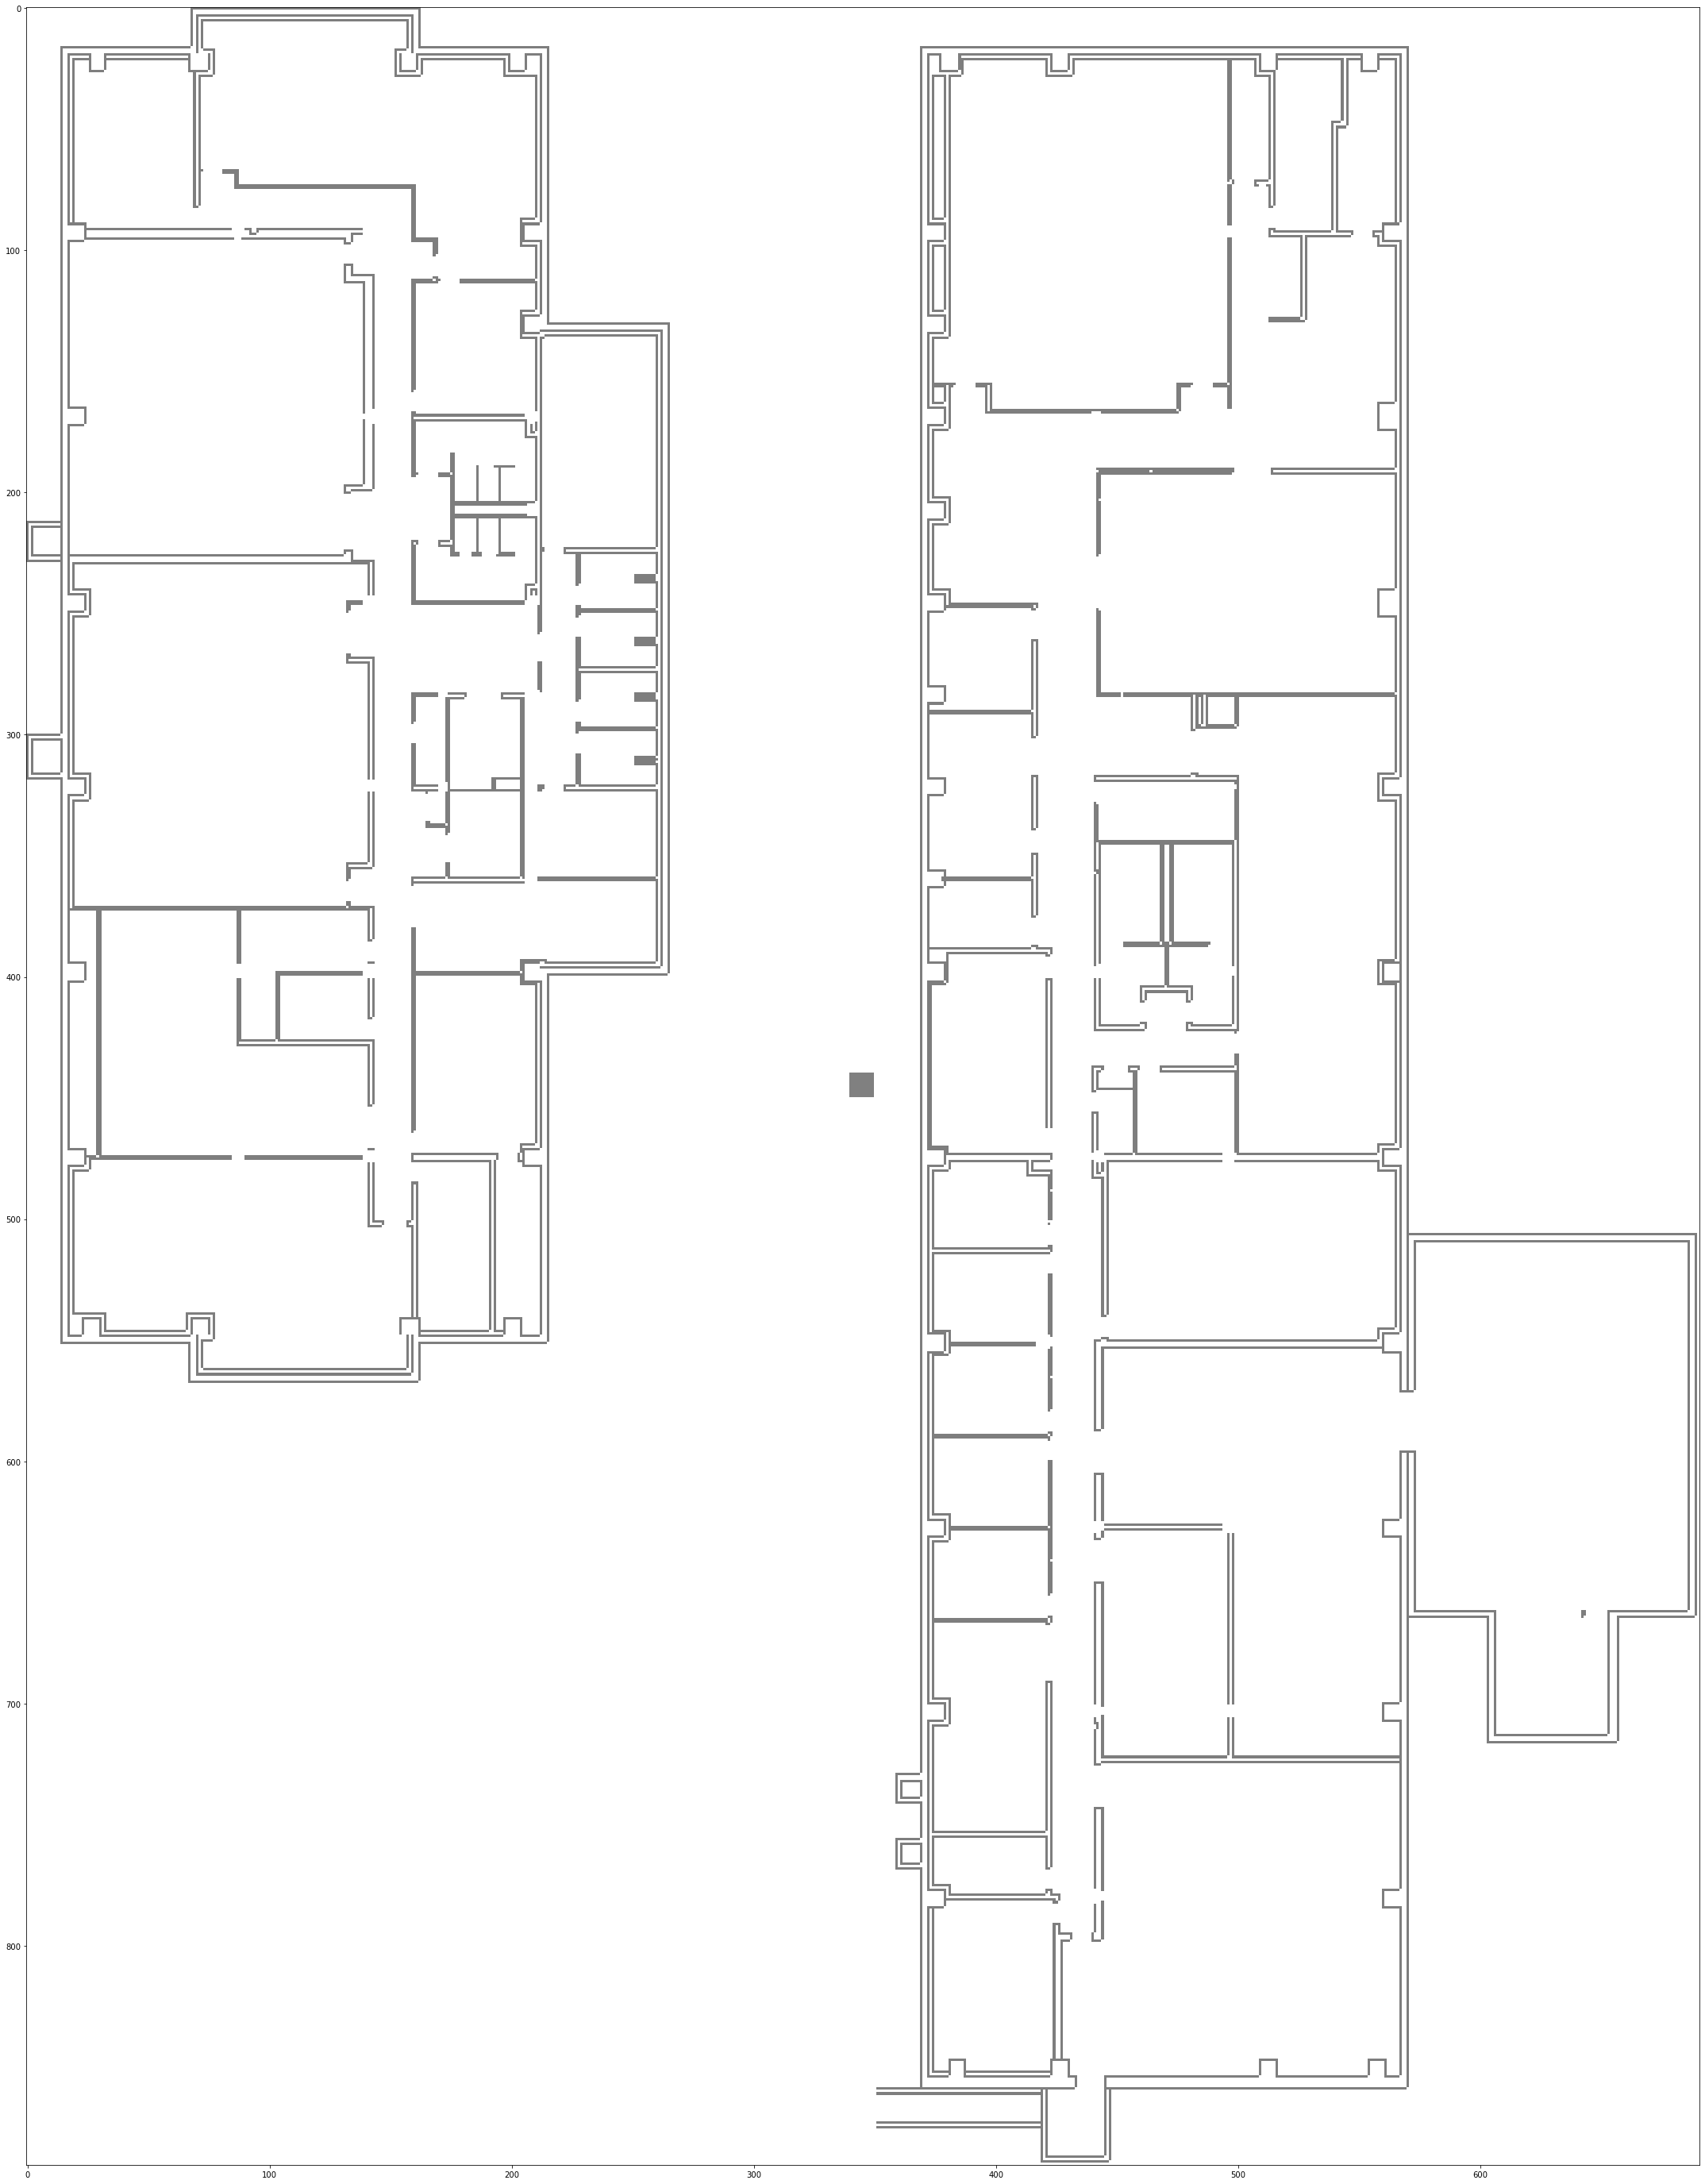

In [74]:
vectormap = get_vectormap("GDC1.vectormap.json")
image_size_x, image_size_y = get_image_size(vectormap)
print("dims:", image_size_x, image_size_y)
x_min, y_min, x_max, y_max = get_image_min_max(vectormap)
map_channel = get_map_channel(vectormap, image_size_x, image_size_y, x_min, y_min)


# initialize agent channel
agent_channel = np.zeros((image_size_x, image_size_y))
agent_x = 0
agent_y = 0
agent_dims = np.array([10, 10])
agent_channel = get_agent_channel(agent_x, agent_y, agent_dims, x_min, y_min, image_size_x, image_size_y)



# mark the agent location on the agent channel


from matplotlib import pyplot as plt
# map_channel = np.rot90(map_channel)
# agent_channel = np.rot90(agent_channel)
plt.figure(figsize=(50, 50))
plt.imshow(map_channel, cmap='binary')
plt.imshow(agent_channel, cmap='binary', alpha=0.5)

In [67]:
import numpy as np
# import pygame
from gymnasium.spaces import MultiBinary
import gymnasium as gym
from gym import spaces
import json
import math

class CCPP_Env(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 20}

    def __init__(self, render_mode=None, map_file = "FinalProject/GDC1.vectormap.json", agent_dims = np.array([1,1]), agent_loc = np.array([0,0]), scaling = 10):
        self.vectormap = get_vectormap(map_file)
        
        # get the size of the image
        self.image_size_x, self.image_size_y = get_image_size(self.vectormap)
        print("x: ", self.image_size_x, "y: ", self.image_size_y)

        #get min values for the offset
        self.x_min, self.y_min, self.x_max, self.y_max = get_image_min_max(self.vectormap)

        

        # get the map channel
        self.map_channel = get_map_channel(self.vectormap, self.image_size_x, self.image_size_y, self.x_min, self.y_min)
        # initialize space visited channel
        self.space_visited_channel = np.zeros((self.image_size_x, self.image_size_y))
        # initialize agent channel
        self.agent_dims = np.array(agent_dims * scaling).astype(int)
        self.agent_channel = get_agent_channel(agent_loc[0], agent_loc[1], self.agent_dims, self.x_min, self.y_min, scaling)

        # make the observation space with 3 channels: 1 for the map, 1 for the agent, 1 for spaces visited
        self.observation_space = spaces.Box(low=0, high=1, shape=(3,self.image_size_x, self.image_size_y), dtype=np.uint8)
        
        # #navigation goal input, 2D vector
        self._action_space = spaces.Box(low=np.array([self.x_min, self.y_min]), high=np.array([self.x_max, self.y_max]), dtype=np.float32)

        self._navigation = np.array([0.0,0.0])  